# Customer Experience Analysis at E-commerce company
The purpose of this analysis is to discover the factors that influence review score most, as well as overall business indexes. The dataset has been provided by a Brazilian online e-commerce company, Olist, and has been accumulated over the past 2 years from Sep 2016 to Sep 2018.

## Table of Contents
1. Data Preprocessing
2. Exploratory Data Analysis
3. Review Reaction Prediction & Feature Importance
3. Conclusion & Action Plan

## 1. Data Preprocessing

In [67]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
import matplotlib.patches as mpatches

In [68]:
items = pd.read_csv("olist_order_items_dataset.csv")
review = pd.read_csv("olist_order_reviews_dataset.csv")
product = pd.read_csv("olist_products_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
payment = pd.read_csv("olist_order_payments_dataset.csv")
translate = pd.read_csv("product_category_name_translation.csv")
customers = pd.read_csv("olist_customers_dataset.csv")

In [69]:
df = pd.merge(review, items, on= 'order_id', how = 'inner')
df= df.merge(product, on = 'product_id', how = 'inner')
df= df.merge(orders, on = 'order_id', how = 'inner')
df= df.merge(payment, on = 'order_id', how = 'inner')
df = df.merge(customers, on = 'customer_id', how = 'inner')
df.head(5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,...,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,...,2018-01-17 18:42:41,2018-02-02 00:00:00,1,credit_card,8,397.26,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,2,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,...,2018-01-17 18:42:41,2018-02-02 00:00:00,1,credit_card,8,397.26,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP
2,e2655da8bccce2ddc2f43cc2c80d24f3,19721d59a9764437477eff0730b48665,5,NaN,NaN,2018-04-10 00:00:00,2018-04-11 11:30:43,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,...,2018-04-09 21:53:23,2018-04-27 00:00:00,1,credit_card,3,205.26,059ba8400bf965adf606ecc7ef3396e9,95860,taquari,RS
3,cb18f53b563f0bdeb76be0376ddd6b6a,efd626e6a12a82d76e456e34093f8356,5,NaN,NaN,2017-12-28 00:00:00,2017-12-30 12:07:50,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,...,2017-12-27 18:19:53,2018-01-08 00:00:00,1,credit_card,2,202.05,62a25a159f9fd2ab7c882d9407f49aa9,36500,uba,MG
4,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,1,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,...,2018-03-09 23:17:20,2018-03-14 00:00:00,1,credit_card,1,88.09,64190b91b656ab8f37eb89b93dc84584,13380,nova odessa,SP


In [70]:
# dropping unnecessary columns for analysis

df = df.drop(columns = ['review_comment_title','freight_value', 'product_name_lenght','product_length_cm', 'product_height_cm', 
                        'product_width_cm', 'customer_zip_code_prefix', 'product_weight_g', 'shipping_limit_date', 'customer_city'])

In [71]:
# replacing Portuguese category names with English names

df = df.join(translate.set_index('product_category_name')['product_category_name_english'], on = 'product_category_name')
df.drop(columns = 'product_category_name', inplace = True)
df.rename({'product_category_name_english': 'product_category'},axis= "columns", inplace = True)
df['product_category'].sample(3)

112714    bed_bath_table
64321      health_beauty
84499          perfumery
Name: product_category, dtype: object

In [72]:
# checking for datatypes - datetime & category

dtime = ['review_creation_date', 'review_answer_timestamp', 'order_purchase_timestamp', 'order_delivered_carrier_date', 'order_delivered_customer_date', 
         'order_estimated_delivery_date', 'order_approved_at']

for d in dtime:
    df[d] = df[d].astype('datetime64')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118315 entries, 0 to 118314
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   review_id                      118315 non-null  object        
 1   order_id                       118315 non-null  object        
 2   review_score                   118315 non-null  int64         
 3   review_comment_message         50665 non-null   object        
 4   review_creation_date           118315 non-null  datetime64[ns]
 5   review_answer_timestamp        118315 non-null  datetime64[ns]
 6   order_item_id                  118315 non-null  int64         
 7   product_id                     118315 non-null  object        
 8   seller_id                      118315 non-null  object        
 9   price                          118315 non-null  float64       
 10  product_description_lenght     116606 non-null  float64       
 11  

In [73]:
# checking for missing values in all columns

df['product_category'] = df['product_category'].fillna("no_data")

avg = ['product_description_lenght', 'product_photos_qty']

for i in avg:
    df[i].fillna(df[i].mean(), inplace = True)
        
# handling missing values

df["order_approved_at"].fillna(df["order_purchase_timestamp"], inplace=True)
df["order_estimated_delivery_date"].fillna(df["order_delivered_customer_date"], inplace=True)
df['order_delivered_carrier_date'].fillna(df['order_approved_at'], inplace = True)
df['order_delivered_customer_date'].fillna(df["order_estimated_delivery_date"], inplace = True)

# update reviews written in Portuguese to "review_contents", since I am not able to use the contents 

df['review_comment_message'].fillna('no_review',inplace=True)
ind = df.query('review_comment_message!= "no_review"').index 
df.loc[ind, 'review_comment_message'] = 'review_given'

df.isna().sum()

review_id                        0
order_id                         0
review_score                     0
review_comment_message           0
review_creation_date             0
review_answer_timestamp          0
order_item_id                    0
product_id                       0
seller_id                        0
price                            0
product_description_lenght       0
product_photos_qty               0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
customer_unique_id               0
customer_state                   0
product_category                 0
dtype: int64

In [74]:
# removing duplicates

df.drop_duplicates(subset = {'order_purchase_timestamp'}, inplace = True)

### Univariate Analysis

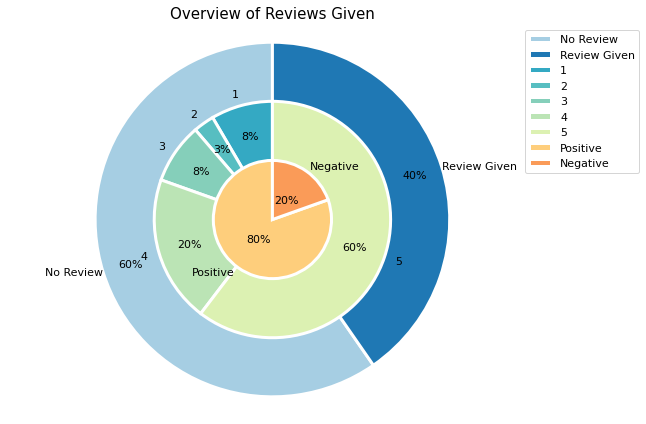

In [130]:
# Let's first divide positive reviews with score higher than 3, and negative reviews with score lower than 3.

def division(x):
    if x<=3:
        return "0"
    else: return "1"

df['reaction'] = df['review_score'].apply(division)
df['reaction'] =df['reaction'].astype(int)

palette = sns.color_palette("Paired", 2)
palette_o = sns.color_palette("YlGnBu", 10)
palette_i = sns.color_palette("Spectral",10)

outer = [palette_o[5],palette_o[4],palette_o[3],palette_o[2], palette_o[1]]
inner = [palette_i[3], palette_i[2]]
color_list = [palette[0], palette[1]]

labels = ['No Review', 'Review Given']
x1 = [df.query('review_comment_message == "no_review"').shape[0], df.query('review_comment_message == "review_given"').shape[0]]
number = df['review_score'].value_counts().sort_index(ascending=True).values
labels_2 = ['1','2', '3', '4', '5']
x2 = [number[0],number[1], number[2], number[3], number[4]]
labels_3 =['Positive','Negative']
x3 = [df['reaction'].value_counts().values[0],df['reaction'].value_counts().values[1]]

plt.figure(figsize=(9,6))
plt.pie(x1, startangle=90, labels = labels, pctdistance =0.84 , colors=color_list,autopct = '%1.0f%%',textprops ={'fontsize':11},
        wedgeprops = {'linewidth' : 3, 'edgecolor' : "w" }, radius= 0.6, labeldistance=1)
plt.pie(x2,startangle=90, labels = labels_2, pctdistance =0.73,colors=outer,textprops ={'fontsize':11},
        wedgeprops = {'linewidth' : 3, 'edgecolor' : "w" }, autopct = '%1.0f%%',radius= 0.4)
plt.pie(x3,startangle=90, labels = labels_3, pctdistance =0.4,colors=inner,textprops ={'fontsize':11},
        wedgeprops = {'linewidth' : 3, 'edgecolor' : "w" }, autopct = '%1.0f%%',radius= 0.2 )
plt.axis('equal') 
plt.legend(loc=1, bbox_to_anchor=(0.8, 0., 0.4, 1), fontsize =11)
plt.title("Overview of Reviews Given", size = 15)
plt.tight_layout();

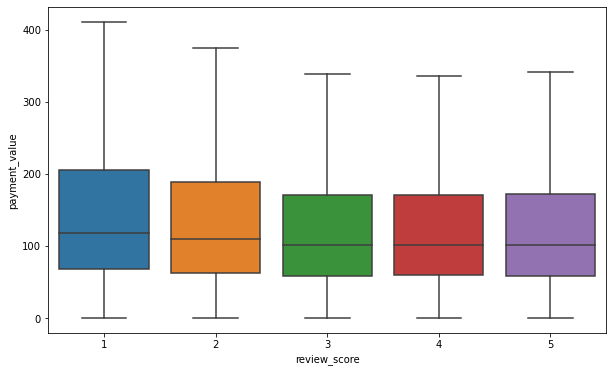

In [76]:
plt.figure(figsize = (10,6))
sns.boxplot(df['review_score'], df['payment_value'], showfliers=False);

In [77]:
df.groupby('review_score')['product_description_lenght'].agg(['mean', 'std'])

,mean,std
review_score,,
1,790.287180,657.237916
2,739.966831,595.357150
3,776.197960,638.905178
4,798.141854,646.169158
5,799.600606,654.582397


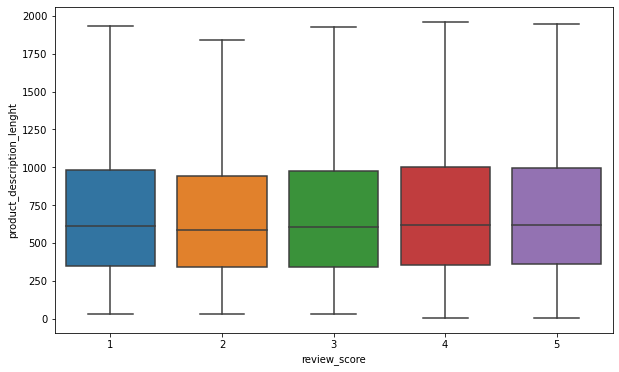

In [78]:
plt.figure(figsize = (10,6))
sns.boxplot(df['review_score'], df['product_description_lenght'], showfliers=False);

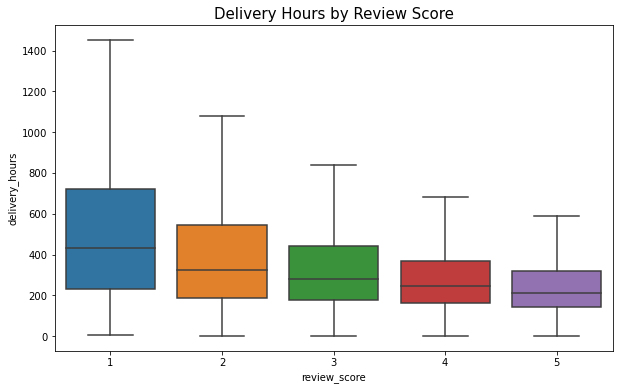

In [79]:
df['delivery_time'] = df['order_delivered_customer_date'] - df['order_approved_at']
df['delivery_hours'] = df['delivery_time'].apply(lambda x: x/np.timedelta64(1,'h'))
df = df.query('delivery_hours > 0') 

plt.figure(figsize =(10,6))
sns.boxplot(df['review_score'], df['delivery_hours'], showfliers = False)
plt.title("Delivery Hours by Review Score", size = 15);

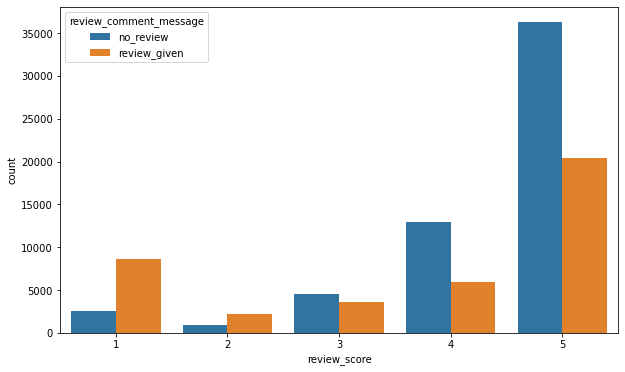

In [80]:
plt.figure(figsize = (10,6))
sns.countplot(df['review_score'], hue = df['review_comment_message']);

In [81]:
df.groupby(['product_category'])['review_score'].mean().sort_values(ascending = False).head(10)

product_category
cds_dvds_musicals            4.666667
la_cuisine                   4.545455
books_general_interest       4.455078
fashion_sport                4.375000
books_imported               4.372549
costruction_tools_tools      4.371134
books_technical              4.370079
food_drink                   4.364865
fashion_childrens_clothes    4.333333
luggage_accessories          4.323242
Name: review_score, dtype: float64

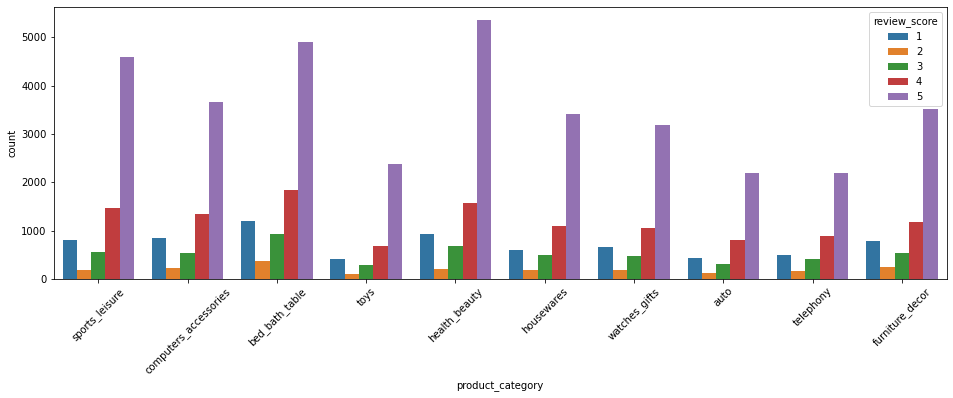

In [82]:
cat_lists = ['bed_bath_table', 'telephony','furniture_decor','computers_accessories','watches_gifts','auto','housewares',
'health_beauty', 'toys','sports_leisure']
df_top10 = df[df['product_category'].isin(cat_lists)]

plt.figure(figsize = (16,5))
sns.countplot(df_top10['product_category'], hue = df_top10['review_score'])
plt.xticks(rotation = 45);

In [83]:
df.groupby(['product_category'])['review_score'].std().sort_values(ascending = False)

product_category
security_and_services                2.121320
fashion_male_clothing                1.674201
home_comfort_2                       1.640640
fashion_childrens_clothes            1.632993
furniture_mattress_and_upholstery    1.539661
                                       ...   
fashion_sport                        1.172604
luggage_accessories                  1.155550
books_general_interest               1.119972
food_drink                           1.058142
cds_dvds_musicals                    0.651339
Name: review_score, Length: 72, dtype: float64

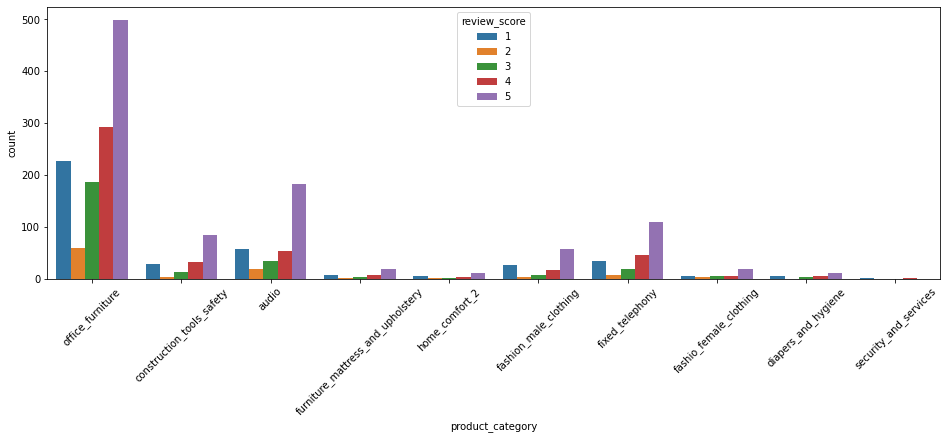

In [84]:
df_bottom_10_mean = df.groupby(['product_category'])['review_score'].mean().sort_values(ascending = True)[:10]
df_bottom_mean = df[df['product_category'].isin(df_bottom_10_mean.index)]
plt.figure(figsize = (16,5))
sns.countplot(df_bottom_mean['product_category'], hue =  df_bottom_mean['review_score'])
plt.xticks(rotation = 45);

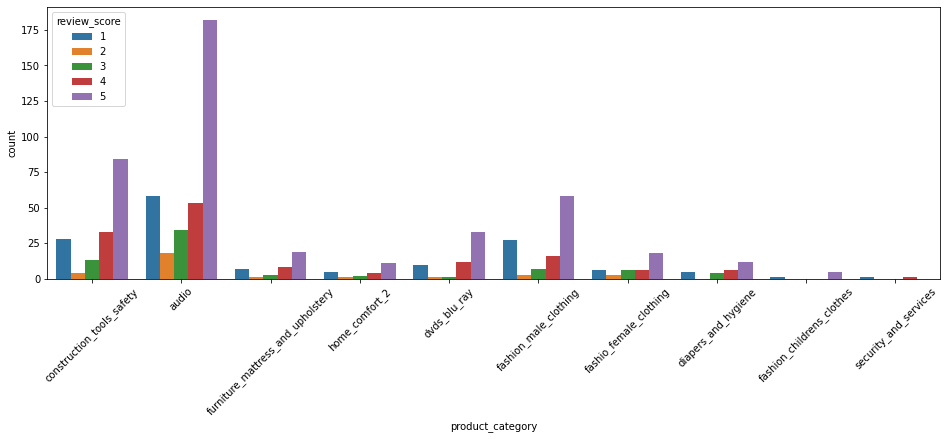

In [85]:
df_bottom_10_std = df.groupby(['product_category'])['review_score'].std().sort_values(ascending = False)[:10]

df_bottom_std = df[df['product_category'].isin(df_bottom_10_std.index)]
plt.figure(figsize = (16,5))
sns.countplot(df_bottom_std['product_category'], hue =  df_bottom_std['review_score'])
plt.xticks(rotation = 45);

In [86]:
df.groupby(['payment_type'])['review_score'].agg(['mean', 'std'])

,mean,std
payment_type,,
boleto,4.092248,1.333755
credit_card,4.089551,1.345388
debit_card,4.175182,1.289387
voucher,4.052372,1.376499


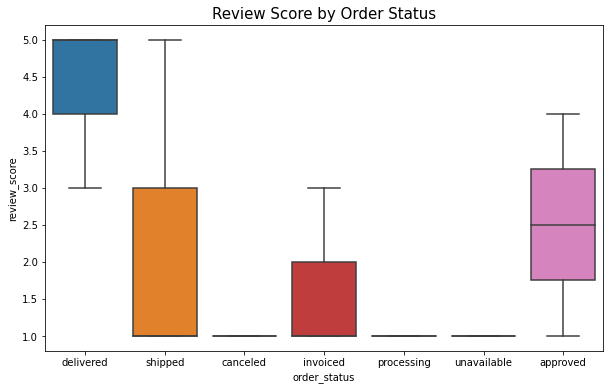

In [87]:
plt.figure(figsize =(10,6))
sns.boxplot(df['order_status'], df['review_score'], showfliers = False)
plt.title("Review Score by Order Status", size = 15);

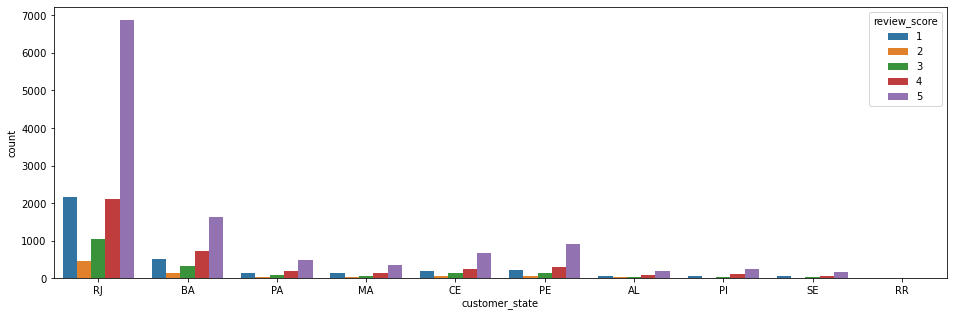

In [88]:
# 최고, 최저 평점 편차가 큰 주들

df_bottom_10_std = df.groupby(['customer_state'])['review_score'].std().sort_values(ascending = False)[:10]
df_bottom_std = df[df['customer_state'].isin(df_bottom_10_std.index)]
plt.figure(figsize = (16,5))
sns.countplot(df_bottom_std['customer_state'], hue =  df_bottom_std['review_score']);

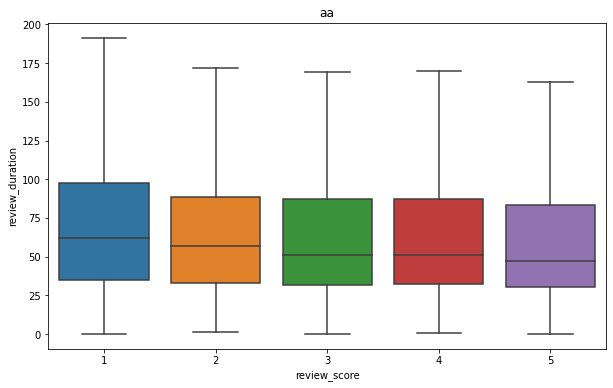

In [89]:
df['review_duration'] = df['review_answer_timestamp'] - df['order_delivered_customer_date']
df['review_duration'] = df['review_duration'].apply(lambda x: x/np.timedelta64(1,'h'))
df = df.query('review_duration > 0') 

plt.figure(figsize = (10,6))
sns.boxplot(df['review_score'], df['review_duration'], showfliers = False)
plt.title('aa');

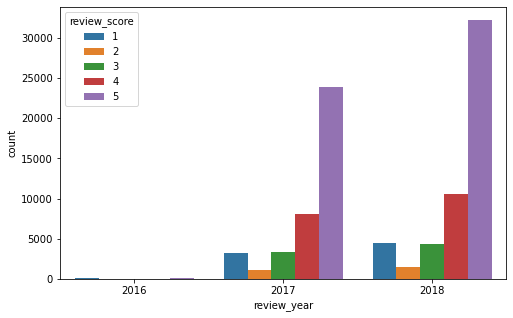

In [90]:
df['review_year'] = df['review_answer_timestamp'].dt.year
df['review_month'] = df['review_answer_timestamp'].dt.month
df['review_dayofweek'] = df['review_answer_timestamp'].dt.dayofweek
df['review_day'] = df['review_answer_timestamp'].dt.day
df['review_hour'] = df['review_answer_timestamp'].dt.hour

plt.figure(figsize = (8,5))
sns.countplot(df['review_year'], hue =  df['review_score']);

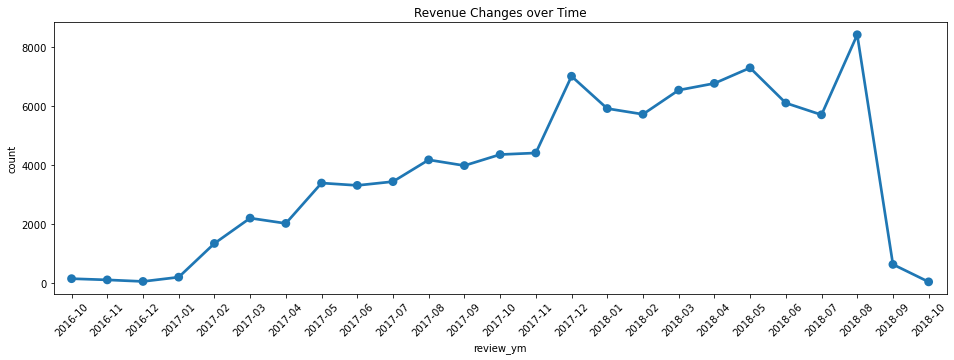

In [91]:
# 그 이유는 주문 제품수의 폭주

df['review_ym'] = df['review_answer_timestamp'].dt.to_period('M')
df_ym = df.groupby('review_ym').size().reset_index(name = 'count')
plt.figure(figsize = (16,5))
sns.pointplot(df_ym['review_ym'], df_ym['count'])
plt.xticks(rotation = 45)
plt.title('Revenue Changes over Time');

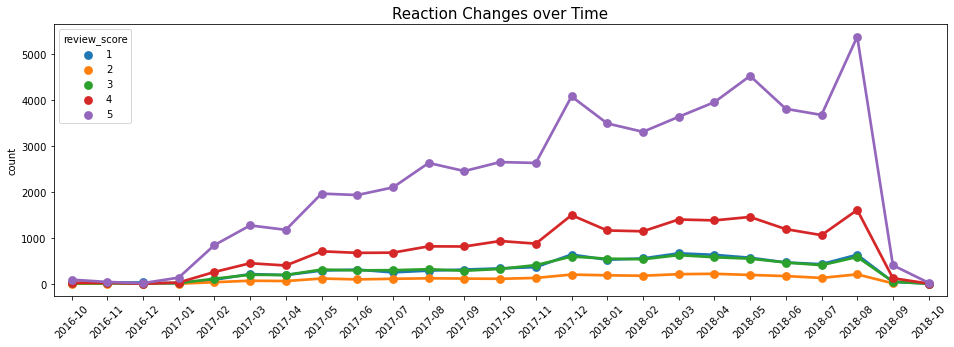

In [92]:
review_ym = df.groupby(['review_ym','review_score']).size().reset_index(name = 'count')
plt.figure(figsize = (16,5))
ax = sns.pointplot(data= review_ym, x = 'review_ym', y = 'count', hue = 'review_score')
plt.xticks(rotation = 45)
plt.xlabel(None)
plt.title("Reaction Changes over Time", size = 15);

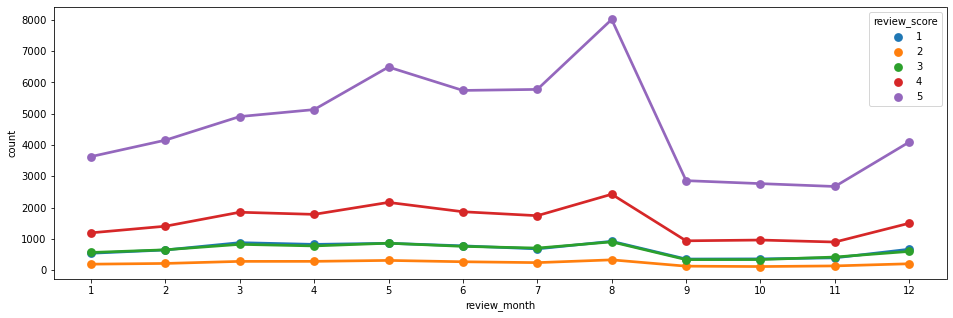

In [93]:
review_m = df.groupby(['review_month','review_score']).size().reset_index(name = 'count')
plt.figure(figsize = (16,5))
sns.pointplot(data= review_m, x = 'review_month', y = 'count', hue = 'review_score');

In [94]:
# 요일 분석

df.groupby(['review_dayofweek'])['review_score'].mean()


review_dayofweek
0    4.180575
1    4.204752
2    4.221167
3    4.212862
4    4.226106
5    4.230668
6    4.194128
Name: review_score, dtype: float64

In [95]:
# 월초,월말 (1주와 4,5주 차이에 주목)

df['week_num'] = np.ceil(df['review_day']/7)
df.groupby(['week_num'])['review_score'].mean()


week_num
1.0    4.211111
2.0    4.208234
3.0    4.213593
4.0    4.214213
5.0    4.197951
Name: review_score, dtype: float64

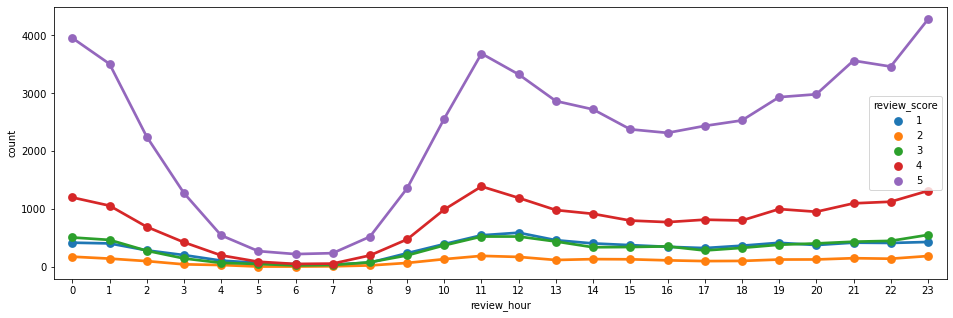

In [96]:
review_h = df.groupby(['review_hour','review_score']).size().reset_index(name = 'count')
plt.figure(figsize = (16,5))
sns.pointplot(data= review_h, x = 'review_hour', y = 'count', hue = 'review_score');

### 고객 특징 뽑아내기

In [97]:
len(df['customer_unique_id'].value_counts()[df['customer_unique_id'].value_counts() >1]) *100 / len(df.groupby(['customer_unique_id']).count()
)

2.591051103432287

In [98]:
df['order_date'] = df['order_approved_at'].dt.date

# 첫 구매에 여러개 구매하는 사람들을 1번 구매라고 올바르게 분류하기 위해

df_unique_users = df.drop_duplicates(subset = ['order_date', 'customer_unique_id'], keep='last')

In [99]:
df_twice_index = df_unique_users['customer_unique_id'].value_counts()[df_unique_users['customer_unique_id'].value_counts() >1].index
# df에서 특정 인덱스만 가져와서 분석 - 2번 이상 구매한 사람들의 특징 추출!!! 

In [100]:
df_unique_users['repurchase'] = df_unique_users['customer_unique_id'].apply(lambda x: x in df_twice_index)

In [101]:
df_unique_users.groupby('repurchase').mean()


,review_score,order_item_id,price,product_description_lenght,product_photos_qty,payment_sequential,payment_installments,payment_value,delivery_hours,review_duration,review_year,review_month,review_dayofweek,review_day,review_hour,week_num
repurchase,,,,,,,,,,,,,,,,
False,4.204637,1.015198,125.874118,796.314407,2.260178,1.022396,2.885863,157.754053,268.210456,87.020248,2017.569435,6.191707,2.970315,16.105213,13.167156,2.749915
True,4.344198,1.027730,109.959348,771.340071,2.177785,1.034055,3.201411,146.684089,256.074800,80.124260,2017.529312,6.235466,3.018487,15.881781,12.909025,2.729020


In [102]:
print(len(df_unique_users.query('repurchase == True & payment_type == "voucher"')) *100 / len(df_unique_users[df_unique_users['repurchase']==True]),
len(df_unique_users.query('repurchase == False & payment_type == "voucher"')) *100/ len(df_unique_users[df_unique_users['repurchase']==False]))

# 실제로 재구매 한 사람들의 voucher 사용율이 높다.

4.135246898564826 2.616495543269773


In [103]:
df_unique_users.query('repurchase == False')['product_category'].value_counts().head(10)

bed_bath_table           8096
health_beauty            7886
sports_leisure           6774
computers_accessories    6062
furniture_decor          5555
housewares               5280
watches_gifts            5042
telephony                3820
auto                     3513
toys                     3504
Name: product_category, dtype: int64

In [104]:
df_unique_users.query('repurchase == True')['product_category'].value_counts().head(10)
# health_beauty 이런거 광고 고려?

bed_bath_table           506
sports_leisure           415
furniture_decor          330
health_beauty            327
housewares               259
computers_accessories    230
watches_gifts            227
garden_tools             153
telephony                146
toys                     146
Name: product_category, dtype: int64

In [105]:
# 판매자 중 점수 낮은사람의 비율? 탈락시키거나.
# 첫 구매, 재구매 고객 중 평점 낮은 셀러 비율

seller_score_index = df_unique_users.groupby(['seller_id'])['review_score'].mean()[df_unique_users.groupby(['seller_id'])['review_score'].mean()<3].index
print(round(len(df_unique_users[(df_unique_users['seller_id'].isin(seller_score_index))&(df_unique_users['repurchase'] == False)]) *100 /
      len(df_unique_users.query('repurchase == False')),2),"%", 
      round(len(df_unique_users[(df_unique_users['seller_id'].isin(seller_score_index))&(df_unique_users['repurchase'] == True)]) *100 /
      len(df_unique_users.query('repurchase == True')),2))

# 확실히 다시 안오는 사람에게는 평균 평점이 3 미만인 셀러 비율이 높다. - 2배 
# 이런 셀러는 penalty를 주거나, 셀러 평점 규정을 만들어야.

1.06 % 0.68


### Classification

In [131]:
df_model = df.drop(columns = ['review_id', 'order_id','order_item_id', 'product_id','seller_id', 'review_score', 'review_creation_date', 'review_answer_timestamp', 'order_purchase_timestamp',
                              'order_approved_at', 'customer_id', 'review_ym', 'order_date', 'order_delivered_carrier_date', 'review_comment_message',
                             'order_delivered_customer_date', 'order_estimated_delivery_date', 'delivery_time','week_num', 'customer_unique_id', 'reaction'])
df_model.isnull().sum()

price                         0
product_description_lenght    0
product_photos_qty            0
order_status                  0
payment_sequential            0
payment_type                  0
payment_installments          0
payment_value                 0
customer_state                0
product_category              0
delivery_hours                0
review_duration               0
review_year                   0
review_month                  0
review_dayofweek              0
review_day                    0
review_hour                   0
dtype: int64

In [132]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
    
c = df_model.columns[df_model.dtypes == 'object']
# 조건을 데이터프레임이 아니라 columns에 건다.

for i in c:
    df_model[i] = le.fit_transform(df_model[i])

In [133]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_model, df['reaction'], test_size = 0.2, random_state = 100)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state = 100)
x_train.shape, x_valid.shape, x_test.shape

((59640, 17), (14910, 17), (18638, 17))

In [134]:
from catboost import CatBoostClassifier
cbc = CatBoostClassifier(verbose = 100, depth = 10)
cbc.fit(x_train, y_train, eval_set=(x_valid, y_valid), early_stopping_rounds=50)

Learning rate set to 0.08699
0:	learn: 0.6511225	test: 0.6520437	best: 0.6520437 (0)	total: 57.4ms	remaining: 57.4s
100:	learn: 0.4038050	test: 0.4613679	best: 0.4607921 (73)	total: 6s	remaining: 53.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4607921472
bestIteration = 73

Shrink model to first 74 iterations.


In [135]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
result_classifier_test = cbc.predict(x_test)
ac = accuracy_score(y_test, result_classifier_test) # proba: 디테일이 필요한 경우만. 
f1 = f1_score(y_test, result_classifier_test, average = 'macro') # average = 'binary'가 디폴트. 그런데 prediction칼럼에는 1-5 다양한 값 있으니 average를 macro나 micro로 바꿔야
cr = classification_report(y_test, result_classifier_test)
cm = confusion_matrix(y_test, result_classifier_test)

In [136]:
ac

0.8243373752548556

In [137]:
f1

0.547122850828913

In [138]:
print(cr)

              precision    recall  f1-score   support

           0       0.83      0.11      0.19      3587
           1       0.82      0.99      0.90     15051

    accuracy                           0.82     18638
   macro avg       0.83      0.55      0.55     18638
weighted avg       0.83      0.82      0.77     18638



In [139]:
cm

array([[  391,  3196],
       [   78, 14973]], dtype=int64)

In [140]:
from sklearn.metrics import log_loss
ll = log_loss(y_test, cbc.predict_proba(x_test))
ll

0.4490635849214207

In [141]:
from sklearn.model_selection import StratifiedKFold  # stratify: 계층화하다. 층을 이루게 하다.
skf = StratifiedKFold(n_splits= 5, shuffle=True, random_state = 42)

result_cv = 0

for train_index, valid_index in skf.split(x_train, y_train): # stratified: 분류문제의 경우 각 fold마다 정답 클래스의 분포를 맞춰서 (5점짜리는 30%, 4점짜리는 20%...) 평가셋 뽑기 위해. 
    xx_train = x_train.iloc[train_index]
    xx_valid = x_train.iloc[valid_index]
    yy_train = y_train.iloc[train_index]
    yy_valid = y_train.iloc[valid_index]
    cbc_cv = CatBoostClassifier(verbose = 100)
    cbc_cv.fit(xx_train, yy_train, eval_set=(xx_valid, yy_valid), early_stopping_rounds=50)
    result_cv+=cbc_cv.predict_proba(x_test)/2  # 이 고객은 더 5점에 가깝다 (확률 %로 세분화)

Learning rate set to 0.082325
0:	learn: 0.6534080	test: 0.6534609	best: 0.6534609 (0)	total: 19.3ms	remaining: 19.2s
100:	learn: 0.4434156	test: 0.4522401	best: 0.4522401 (100)	total: 1.06s	remaining: 9.42s
200:	learn: 0.4302613	test: 0.4506081	best: 0.4506081 (200)	total: 2.07s	remaining: 8.22s
300:	learn: 0.4181284	test: 0.4501837	best: 0.4500060 (270)	total: 3.04s	remaining: 7.07s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4500059626
bestIteration = 270

Shrink model to first 271 iterations.
Learning rate set to 0.082325
0:	learn: 0.6531223	test: 0.6535791	best: 0.6535791 (0)	total: 19.7ms	remaining: 19.7s
100:	learn: 0.4428380	test: 0.4566660	best: 0.4566660 (100)	total: 1.08s	remaining: 9.59s
200:	learn: 0.4299481	test: 0.4555937	best: 0.4553890 (174)	total: 2.09s	remaining: 8.32s
300:	learn: 0.4178038	test: 0.4553457	best: 0.4551827 (250)	total: 3.08s	remaining: 7.16s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4551827443
bestItera

In [150]:
ac = accuracy_score(y_test, result_cv.argmax(1)) 
f1 = f1_score(y_test, result_cv.argmax(1), average = 'macro') 
cr = classification_report(y_test, result_cv.argmax(1))
cm = confusion_matrix(y_test, result_cv.argmax(1))

In [148]:
ac

0.8238008369996781

In [149]:
f1

0.5511694153380887

In [151]:
print(cr)

              precision    recall  f1-score   support

           0       0.79      0.12      0.20      3587
           1       0.82      0.99      0.90     15051

    accuracy                           0.82     18638
   macro avg       0.81      0.55      0.55     18638
weighted avg       0.82      0.82      0.77     18638



In [152]:
cm

array([[  414,  3173],
       [  111, 14940]], dtype=int64)

In [121]:
cbc.feature_importances_
pd.Series(cbc.feature_importances_, index = x_train.columns).sort_values(ascending = False)

order_status                  11.863518
delivery_hours                11.608100
payment_value                 10.473396
price                         10.266989
product_category               7.274446
review_duration                5.583670
review_hour                    5.336960
customer_state                 5.224175
review_dayofweek               5.214237
review_day                     4.964169
review_month                   4.493833
product_description_lenght     4.277322
payment_installments           4.085744
product_photos_qty             4.004615
review_year                    3.203669
payment_type                   2.026616
payment_sequential             0.098540
dtype: float64

In [128]:
from eli5.sklearn import PermutationImportance
import eli5

permutation = PermutationImportance(cbc).fit(x_valid, y_valid) 
eli5.show_weights(permutation, feature_names = x_valid.columns.tolist()) 

Weight,Feature
0.0280 ± 0.0013,order_status
0.0219 ± 0.0013,price
0.0191 ± 0.0019,payment_value
0.0008 ± 0.0005,product_category
0.0008 ± 0.0008,delivery_hours
0.0005 ± 0.0006,product_photos_qty
0.0005 ± 0.0004,product_description_lenght
0.0005 ± 0.0006,review_day
0.0004 ± 0.0004,payment_installments
0.0004 ± 0.0003,review_duration


### Conclusion & Action Plan